# ทดสอบการ Load Model กลับมา

In [17]:
# First, we are going to load the file names and their respective target labels into numpy array! 
from sklearn.datasets import load_files
import numpy as np

train_dir = 'fruits-360/Training'
test_dir = 'fruits-360/Test'

def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels
    
x_train, y_train,target_labels = load_dataset(train_dir)
x_test, y_test,_ = load_dataset(test_dir)
print('Loading complete!')

print('Training set size : ' , x_train.shape[0])
print('Testing set size : ', x_test.shape[0])



Loading complete!
Training set size :  1446
Testing set size :  481


In [18]:
# Let's confirm the number of classes :p
no_of_classes = len(np.unique(y_train))
no_of_classes

3

In [19]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train,no_of_classes)
y_test = np_utils.to_categorical(y_test,no_of_classes)
y_train[0] # Note that only one element has value 1(corresponding to its label) and others are 0.

array([0., 0., 1.], dtype=float32)

In [20]:
# Now, we have to divide the validation set into test and validation set
x_test,x_valid = x_test[240:],x_test[:240]
y_test,y_valid = y_test[240:],y_test[:240]
print('Vaildation X : ',x_valid.shape)
print('Vaildation y :',y_valid.shape)
print('Test X : ',x_test.shape)
print('Test y : ',y_test.shape)

Vaildation X :  (240,)
Vaildation y : (240, 3)
Test X :  (241,)
Test y :  (241, 3)


In [21]:
x_train[0]
# training data is just file names of images. We need to convert them into pixel matrix.

'fruits-360/Training/Watermelon/236_100.jpg'

In [22]:
# We just have the file names in the x set. Let's load the images and convert them into array.
#from keras.preprocessing.image import array_to_img, img_to_array, load_img
import tensorflow as tf 

def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        # Convert to Numpy Array tf.keras.utils.array_to_img
        images_as_array.append(tf.keras.preprocessing.image.img_to_array(tf.keras.utils.load_img(file)))
    return images_as_array

x_train = np.array(convert_image_to_array(x_train))
print('Training set shape : ',x_train.shape)

x_valid = np.array(convert_image_to_array(x_valid))
print('Validation set shape : ',x_valid.shape)

x_test = np.array(convert_image_to_array(x_test))
print('Test set shape : ',x_test.shape)

print('1st training image shape ',x_train[0].shape)


Training set shape :  (1446, 100, 100, 3)
Validation set shape :  (240, 100, 100, 3)
Test set shape :  (241, 100, 100, 3)
1st training image shape  (100, 100, 3)


In [23]:
# time to re-scale so that all the pixel values lie within 0 to 1
x_train = x_train.astype('float32')/255
x_valid = x_valid.astype('float32')/255
x_test = x_test.astype('float32')/255

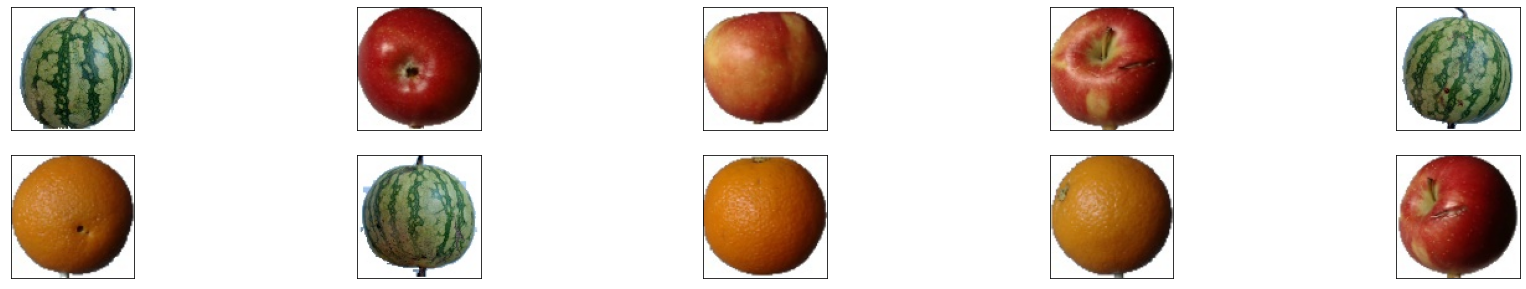

In [24]:
#Let's visualize the first 10 training images!
import matplotlib.pyplot as plt

fig = plt.figure(figsize =(30,5))
for i in range(10):
    ax = fig.add_subplot(2,5,i+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(x_train[i]))
# Yummy fruits ;) 

In [25]:
#Simple CNN from scratch - we are using 3 Conv layers followed by maxpooling layers.
# At the end we add dropout, flatten and some fully connected layers(Dense).

from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D
from keras.layers import Activation, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras import backend as K

model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 2,input_shape=(100,100,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 32,kernel_size = 2,activation= 'relu',padding='same'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 64,kernel_size = 2,activation= 'relu',padding='same'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 128,kernel_size = 2,activation= 'relu',padding='same'))
model.add(MaxPooling2D(pool_size=2))

model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(150))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(3,activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 16)      208       
                                                                 
 activation (Activation)     (None, 100, 100, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 64)        8

In [26]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
print('Compiled!')

Compiled!


# load_weights

In [27]:
# load the weights that yielded the best validation accuracy
model.load_weights('cnn_fruits.hdf5')

In [28]:
# evaluate and print test accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])
#98% accuracy !!


 Test accuracy: 1.0


8/8 [==============================] - 0s 19ms/step


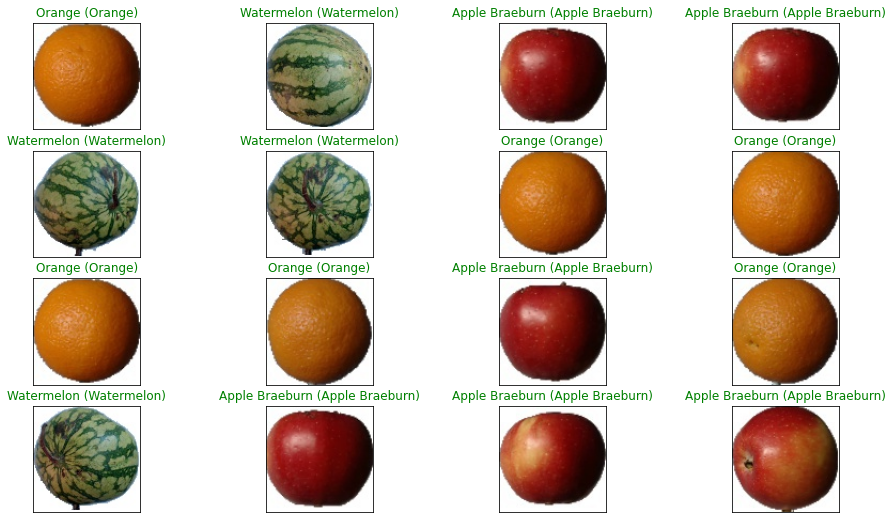

In [29]:
# Let's visualize test prediction.

y_pred = model.predict(x_valid)

# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(16, 9))
for i, idx in enumerate(np.random.choice(x_valid.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_valid[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_valid[idx])
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))